In [1]:
import os
os.chdir('../')

import warnings
warnings.filterwarnings('ignore')

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import os

!nvidia-smi
os.environ["CUDA_VISIBLE_DEVICES"]="2"

Fri Jan 12 00:34:22 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.147.05   Driver Version: 525.147.05   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA RTX A5000    Off  | 00000000:1B:00.0 Off |                    0 |
| 30%   25C    P8    13W / 230W |      8MiB / 23028MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA RTX A5000    Off  | 00000000:1C:00.0 Off |                  Off |
| 30%   

### Model Parts

In [3]:
from model.main.enc_latent_dec import Model
from model.encoder.conv2d_encoder import Encoder
from model.latent_layer.lse_latent_layer import LatentLayer
from model.decoder.conv2d_decoder import Decoder

from tensorboardX import SummaryWriter
from util.util import *


### Model Init.

In [4]:
from easydict import EasyDict
hp = EasyDict()
hp.size = 64
hp.in_dim = 1
hp.out_dim = 1
hp.z_dim = 2
hp.h_dims = [32, 64, 128, 256, 512]

In [5]:
step = 0
device = 'cuda:0'

model = Model(Encoder(**hp), LatentLayer(**hp), Decoder(**hp))
model = model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)

for name, module in model.named_modules():
    if len(name.split('.')) <= 2 and len(name) > 0:
        print(name, get_size(module))
        
print('done')

encoder 6.004646301269531
encoder.convs 5.989013671875
encoder.linear 0.01563262939453125
latent_layer 0.0
decoder 6.044322967529297
decoder.linear 0.0234375
decoder.convs 5.9820556640625
decoder.out_conv 0.038829803466796875
done


### Load

In [6]:
save_dir = '/data/scpark/save/lse/train01.11-6/'
!mkdir -p $save_dir
!ls -lt $save_dir

writer = SummaryWriter(save_dir)

if False:
    step, net_g, _, opt_g, _ = load(save_dir, 0, model, optimizer)

total 144900
-rw-rw-r-- 1 scpark scpark   765092  1월 12 00:09 events.out.tfevents.1704985403.GPUSVR01
-rw-rw-r-- 1 scpark scpark 37973949  1월 12 00:03 save_0
-rw-rw-r-- 1 scpark scpark   661988  1월 12 00:03 events.out.tfevents.1704985057.GPUSVR01
-rw-rw-r-- 1 scpark scpark   352388  1월 11 23:57 events.out.tfevents.1704984873.GPUSVR01
-rw-rw-r-- 1 scpark scpark   379556  1월 11 23:54 events.out.tfevents.1704984673.GPUSVR01
-rw-rw-r-- 1 scpark scpark  1108004  1월 11 22:02 events.out.tfevents.1704977562.GPUSVR01
-rw-rw-r-- 1 scpark scpark 37979741  1월 11 22:01 save_10000
-rw-rw-r-- 1 scpark scpark   910724  1월 11 21:52 events.out.tfevents.1704977066.GPUSVR01
-rw-rw-r-- 1 scpark scpark  2024816  1월 11 21:44 events.out.tfevents.1704976027.GPUSVR01
-rw-rw-r-- 1 scpark scpark 66192541  1월 11 21:43 save_20000


### Dataset

In [7]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Transformations applied on each image
transform = transforms.Compose([
    transforms.Resize((64, 64)),  # Resize the image to 32x32
    transforms.ToTensor(),         # Convert the image to a PyTorch tensor
    transforms.Normalize((0.5), (0.5)) 
])

# Load the MNIST dataset
mnist_trainset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
mnist_testset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Create data loaders
train_loader = DataLoader(mnist_trainset, batch_size=128, shuffle=True)
test_loader = DataLoader(mnist_testset, batch_size=2048, shuffle=True)
print('done')

done


### Preprocess

In [8]:
def preprocess(batch):
    x, t = batch
    data = {}
    data['x'] = x.to(device)
    data['t'] = t.to(device)
    return data

### Train

In [9]:
def plot(x):
    _x = x.data.cpu().numpy()
    plt.figure(figsize=[18, 4])
    for i in range(10):
        plt.subplot(1, 10, i+1)
        plt.imshow(_x[i, 0])
        plt.xticks([])
        plt.yticks([])
    plt.show()
    
# borrowed from https://gist.github.com/jakevdp/91077b0cae40f8f8244a
def discrete_cmap(N, base_cmap=None):
    """Create an N-bin discrete colormap from the specified input map"""

    # Note that if base_cmap is a string or None, you can simply do
    #    return plt.cm.get_cmap(base_cmap, N)
    # The following works for string, None, or a colormap instance:

    base = plt.cm.get_cmap(base_cmap)
    color_list = base(np.linspace(0, 1, N))
    cmap_name = base.name + str(N)
    return base.from_list(cmap_name, color_list, N)


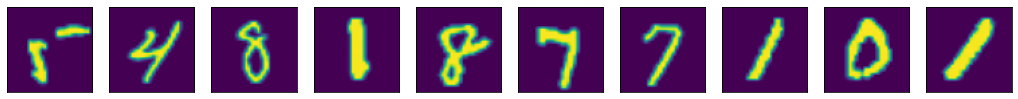

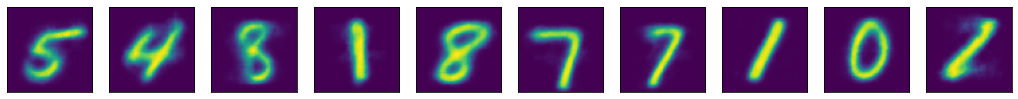

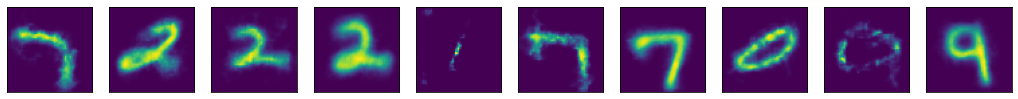

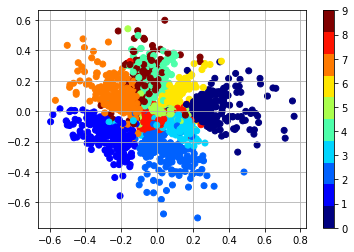

21001
lse_loss -3.853158473968506
recon_loss 0.09781261533498764
21002
lse_loss -3.874647617340088
recon_loss 0.09254825115203857
21003
lse_loss -3.8542652130126953
recon_loss 0.10139212012290955
21004
lse_loss -3.8590304851531982
recon_loss 0.10677679628133774
21005
lse_loss -3.8325788974761963
recon_loss 0.1101960763335228
21006
lse_loss -3.8441832065582275
recon_loss 0.10322912037372589
21007
lse_loss -3.856205701828003
recon_loss 0.10142765939235687
21008
lse_loss -3.8660151958465576
recon_loss 0.10767444223165512
21009
lse_loss -3.8513131141662598
recon_loss 0.10316946357488632
21010
lse_loss -3.843700408935547
recon_loss 0.10843738168478012
21011
lse_loss -3.855358600616455
recon_loss 0.1096639484167099
21012
lse_loss -3.8397562503814697
recon_loss 0.10439084470272064
21013
lse_loss -3.8501505851745605
recon_loss 0.09777956455945969
21014
lse_loss -3.848264694213867
recon_loss 0.11000683158636093
21015
lse_loss -3.8534185886383057
recon_loss 0.0973019227385521
21016
lse_loss -3.8

21128
lse_loss -3.851952314376831
recon_loss 0.10754302144050598
21129
lse_loss -3.850770950317383
recon_loss 0.10356326401233673
21130
lse_loss -3.84782338142395
recon_loss 0.10106419026851654
21131
lse_loss -3.848781108856201
recon_loss 0.1023414358496666
21132
lse_loss -3.864492177963257
recon_loss 0.10428106784820557
21133
lse_loss -3.842988967895508
recon_loss 0.10610809177160263
21134
lse_loss -3.855530023574829
recon_loss 0.1035744696855545
21135
lse_loss -3.8461806774139404
recon_loss 0.10998263210058212
21136
lse_loss -3.847989082336426
recon_loss 0.10639657080173492
21137
lse_loss -3.8415815830230713
recon_loss 0.10288795828819275
21138
lse_loss -3.859285354614258
recon_loss 0.10652565956115723
21139
lse_loss -3.842754602432251
recon_loss 0.10895271599292755
21140
lse_loss -3.850907325744629
recon_loss 0.11054398864507675
21141
lse_loss -3.860215187072754
recon_loss 0.09891252964735031
21142
lse_loss -3.8468897342681885
recon_loss 0.10602830350399017
21143
lse_loss -3.8278937

21258
lse_loss -3.85210919380188
recon_loss 0.10350988805294037
21259
lse_loss -3.842730760574341
recon_loss 0.10902969539165497
21260
lse_loss -3.8412060737609863
recon_loss 0.11029144376516342
21261
lse_loss -3.8433210849761963
recon_loss 0.08940456807613373
21262
lse_loss -3.8601269721984863
recon_loss 0.09490184485912323
21263
lse_loss -3.8529300689697266
recon_loss 0.1020294725894928
21264
lse_loss -3.8369171619415283
recon_loss 0.1072297915816307
21265
lse_loss -3.8550820350646973
recon_loss 0.1035832092165947
21266
lse_loss -3.8623263835906982
recon_loss 0.09527435153722763
21267
lse_loss -3.858797550201416
recon_loss 0.10199940204620361
21268
lse_loss -3.851832389831543
recon_loss 0.10343974083662033
21269
lse_loss -3.8533265590667725
recon_loss 0.09966331720352173
21270
lse_loss -3.860926866531372
recon_loss 0.10031464695930481
21271
lse_loss -3.8507936000823975
recon_loss 0.10428620874881744
21272
lse_loss -3.8546483516693115
recon_loss 0.09822291135787964
21273
lse_loss -3.8

21387
lse_loss -3.8516061305999756
recon_loss 0.10141091793775558
21388
lse_loss -3.8476288318634033
recon_loss 0.09742802381515503
21389
lse_loss -3.857653856277466
recon_loss 0.10284306854009628
21390
lse_loss -3.8500843048095703
recon_loss 0.10376998037099838
21391
lse_loss -3.8436453342437744
recon_loss 0.0940542072057724
21392
lse_loss -3.8523921966552734
recon_loss 0.0937829464673996
21393
lse_loss -3.853761672973633
recon_loss 0.1016865223646164
21394
lse_loss -3.8428709506988525
recon_loss 0.10680115222930908
21395
lse_loss -3.8521323204040527
recon_loss 0.0961182713508606
21396
lse_loss -3.8348593711853027
recon_loss 0.10346323251724243


In [ ]:
from IPython import display

while True:
    for batch in train_loader:
        print(step)
        
        data = preprocess(batch)
        
        # Forward
        model.train()
        model.zero_grad()
        data = model(data, M=10000, sigma=1e-0)
        
        # Backward
        loss = 0
        for key in data.keys():
            if 'loss' in key:
                loss = loss + data[key]
                writer.add_scalar(key, data[key].item(), step)
                print(key, data[key].item())
        loss.backward()
        optimizer.step()
        
        if step % 1000 == 0:
            import matplotlib.pyplot as plt
            display.clear_output()
            
            batch = next(iter(test_loader))
            data = preprocess(batch)
            
            model.eval()
            with torch.no_grad():
                data = model(data, M=1000, sigma=1e-1)
            
            plot(data['x'])
            plot(data['y'])
            
            with torch.no_grad():
                z = torch.randn(10, hp.z_dim).to(device)
                y = model.sample(z)
                plot(y)
                
            import matplotlib.pyplot as plt
            _z = data['z'].data.cpu().numpy()
            plt.scatter(_z[:, 0], _z[:, 1], c=data['t'].data.cpu().numpy(), cmap=discrete_cmap(10, 'jet'))
            plt.grid()
            plt.colorbar()
            plt.show()
        
        if step % 10000 == 0:
            save(save_dir, step, model, optimizer)
                
        step += 1
        